In [ ]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import NAdam
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import os
import random
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip - '/content/drive/MyDrive/cat_136/cat_136.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/cat_136/cat_136.zip
replace cat_136/flickr_cat_000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="/content/cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size

    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop,
                  y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size),
                         interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1

    def __len__(self):
        return len(self.photo_names)

In [ ]:
class DatasetModule(Dataset):
    def __init__(self, path, size, interpolation_type=cv2.INTER_NEAREST,
                 *augmentation_par):
        super().__init__()
        '''
        cv.INTER_NEAREST — интерполяция методом ближайшего соседа
        (nearest-neighbor interpolation);

        cv.INTER_LINEAR — билинейная интерполяция
        (bilinear interpolation (используется по умолчанию);

        cv.INTER_CUBIC — бикубическая интерполяция (bicubic interpolation)
        в окрестности 4×4 пикселей;

        cv.INTER_AREA — передискретизации с использованием отношения площади
        пикселя;

        cv.INTER_LANCZOS4 — интерполяция Ланцоша (Lanczos interpolation)
         в окрестности 8×8 пикселей;

        augmentation_par: (type str) <- в разработке,
        по перадаче аргументом должно применяться к изображениям
        и добавлять
        '''
        self.path = path
        self.collections = os.listdir(path)
        self.size = size
        self.interpolation_type = interpolation_type
        self.augmentation = augmentation_par

    def __getitem__(self, index):
        im = self.path + '/' + self.collections[index]
        im = cv2.imread(im)
        im = cv2.resize(im, (self.size, self.size),
                        interpolation=self.interpolation_type)
        return im

    def __len__(self):
      return len(self.collections)



In [ ]:
class Discriminator(nn.Module):
        def __init__(self,start_size=2, downsamplings=6, start_channels=8):
            super().__init__()

            self.start_channels = start_channels
            self.downsamplings = downsamplings


            self.inptl = nn.Conv2d(in_channels=3, out_channels=self.start_channels,
                               kernel_size=1,stride=1,padding=0)

            self.dwn = self.downsamplings_layers()
            self.flt = nn.Flatten()

            self.linear = nn.Linear(self.start_channels*2**(self.downsamplings)*2*2,1)
            self.sigma = nn.Sigmoid()


        def downsamplings_layers(self):
            res = []
            self.c = self.start_channels
            for _ in range(self.downsamplings):
                res += [nn.Conv2d(in_channels=self.c,out_channels=self.c*2,
                              kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(self.c*2),
                nn.ReLU()]
                self.c *= 2

            res = nn.ModuleList(res)
            return nn.Sequential(*res)

        def forward(self, x):

            x = self.inptl(x)
            x = self.dwn(x)
            x = self.flt(x)
            x = self.linear(x)
            x = self.sigma(x)

            return x



In [ ]:
class Generator(nn.Module):
    def __init__(self, start_size=2,latent_size=32,start_channels=1024,
                 upsamplings=6):
        super().__init__()
        self.start_size = start_size
        self.latent_size = latent_size
        self.start_channels = start_channels
        self.upsamplings = upsamplings
        self.inputConv2d = nn.Conv2d(self.latent_size, self.start_channels,
                                     kernel_size=1, stride=1, padding=0)


        self.upsmpl = self.upsamplings_layers()

        self.convout = nn.Conv2d(in_channels=self.start_channels//(
                                 2**(self.upsamplings)),
                                 out_channels=3,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.pred = nn.Tanh()


    def upsamplings_layers(self):
        res = []
        self.c =  self.start_channels
        for _ in range(self.upsamplings):
            res += [nn.ConvTranspose2d(in_channels=self.c,
                                       out_channels=self.c // 2,
                                       kernel_size=4,
                                       stride=2,padding=1),
                nn.BatchNorm2d(self.c // 2),
                nn.ReLU()]
            self.c //= 2
        res = nn.ModuleList(res)
        return nn.Sequential(*res)


    def forward(self, batch_size):
        z = torch.randn(batch_size, self.latent_size, self.start_size , self.start_size ).cuda()

        z = self.inputConv2d(z)
        z = self.upsmpl(z)
        z = self.convout(z)
        z = self.pred(z)


        return z


In [ ]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def train_gan():
    generator = Generator()
    discriminator = Discriminator()
    generator.cuda()
    discriminator.cuda()
    epochs = 120
    visualise_every = 10
    batch_size = 8


    gen_optim = NAdam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    disc_optim = NAdam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    dataset = CatDataset(size=128)

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        gen_loss_avg = 0
        disc_loss_avg = 0

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            # Positive update
            batch = batch.cuda()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Negative update
            batch = generator(batch_size).detach()
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.zeros_like(pred))
            disc_optim.zero_grad()
            loss.backward()
            disc_optim.step()
            disc_loss_avg += loss.item()

            # Generator update
            batch = generator(batch_size)
            pred = discriminator(batch)
            loss = F.binary_cross_entropy(pred, torch.ones_like(pred))
            gen_optim.zero_grad()
            loss.backward()
            gen_optim.step()
            gen_loss_avg += loss.item()

        if (ep + 1) % visualise_every == 0:
            with torch.no_grad():
                visualise(generator(6), rows=2)

        print(f"Epoch {ep+1} | Discriminator loss: {disc_loss_avg / total_batches} | Generator loss: {gen_loss_avg / total_batches}" )

In [ ]:
class DCGAN(nn.Module):
    def __init__(self, start_size=2, latent_size=32, start_channels=1024,
                 upsampling=6, downsampling=6, end_channels=8):
        super().__init__()

        self.generator = Generator(start_size=start_size,
                                   latent_size=latent_size,
                                   start_channels=start_channels,
                                   upsamplings=upsampling)

        self.discriminator = Discriminator(start_size=start_size,
                                           downsamplings=downsampling,
                                           start_channels=end_channels)
    def forward(self, *bs_x):
        bs, x = bs_x
        true_img = self.discriminator.forward(x)
        fake_img_to_eq = self.generator.forward(bs).detach()
        fake_img_to_upd = self.generator.forward(bs)

        return true_img, fake_img_to_eq, fake_img_to_upd

    def save(self):
         torch.save(self.state_dict(),'/content/drive/MyDrive/GAN_pockemon/m.pth')

    def load(self):
        self.load_state_dict(self,torch.load('/content/drive/MyDrive/GAN_pockemon/m.pth',map_location=torch.device('cpu') ))
        return self.eval()

  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 | Discriminator loss: 0.6497213802486947 | Generator loss: 3.413559427450162


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 | Discriminator loss: 0.954003100558213 | Generator loss: 2.643118040902274


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 3 | Discriminator loss: 1.0158178560227527 | Generator loss: 2.443551325464841


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 4 | Discriminator loss: 1.0793338209413779 | Generator loss: 2.1147404805473657


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 5 | Discriminator loss: 1.0820121924213557 | Generator loss: 1.8501459307367016


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 6 | Discriminator loss: 1.0439578183342395 | Generator loss: 1.8611332587203624


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 7 | Discriminator loss: 0.9465283093950856 | Generator loss: 2.0014527744573094


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 8 | Discriminator loss: 0.8921894242969682 | Generator loss: 2.1181222219829974


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 9 | Discriminator loss: 0.8342214238263018 | Generator loss: 2.2108104269697058


  0%|          | 0/645 [00:00<?, ?it/s]

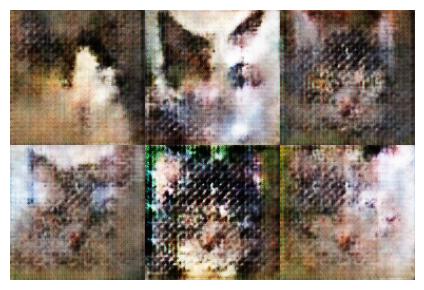

Epoch 10 | Discriminator loss: 0.8125355594114673 | Generator loss: 2.292932768971283


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 11 | Discriminator loss: 0.7691206779151646 | Generator loss: 2.402695054870955


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 12 | Discriminator loss: 0.7055901684002917 | Generator loss: 2.551344684839989


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 13 | Discriminator loss: 0.667135780083915 | Generator loss: 2.6954285285857895


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 14 | Discriminator loss: 0.6208838897804956 | Generator loss: 2.824630085725962


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 15 | Discriminator loss: 0.5960514312646183 | Generator loss: 2.927535977700482


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 16 | Discriminator loss: 0.5668202517402318 | Generator loss: 3.0902722621371286


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 17 | Discriminator loss: 0.5717243714054168 | Generator loss: 3.128554371943385


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 18 | Discriminator loss: 0.4768217092924766 | Generator loss: 3.40343299415541


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 19 | Discriminator loss: 0.5263240489384206 | Generator loss: 3.305677450684287


  0%|          | 0/645 [00:00<?, ?it/s]

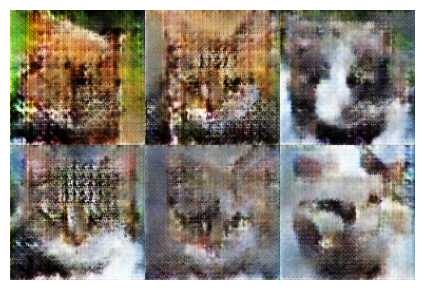

Epoch 20 | Discriminator loss: 0.4912909220330893 | Generator loss: 3.296245469439844


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 21 | Discriminator loss: 0.434995199199248 | Generator loss: 3.5414878202151066


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 22 | Discriminator loss: 0.45459140046698154 | Generator loss: 3.639284707374454


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 23 | Discriminator loss: 0.44071374273552016 | Generator loss: 3.5546490368635757


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 24 | Discriminator loss: 0.42975920397388423 | Generator loss: 3.6283438183506083


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 25 | Discriminator loss: 0.4006225462426809 | Generator loss: 3.7588026388461544


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 26 | Discriminator loss: 0.39724571427318806 | Generator loss: 3.8186970958428352


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 27 | Discriminator loss: 0.3754207010133993 | Generator loss: 3.9106100108127415


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 28 | Discriminator loss: 0.38128236698864854 | Generator loss: 3.927561469052149


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 29 | Discriminator loss: 0.37989188547053004 | Generator loss: 3.9416576369393685


  0%|          | 0/645 [00:00<?, ?it/s]

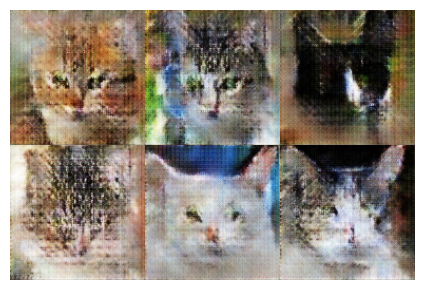

Epoch 30 | Discriminator loss: 0.3772545836277092 | Generator loss: 3.873560227407432


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 31 | Discriminator loss: 0.3661019943754593 | Generator loss: 4.010464209114542


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 32 | Discriminator loss: 0.3587388377840488 | Generator loss: 4.038852061914361


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 33 | Discriminator loss: 0.35555312122847477 | Generator loss: 4.114426424044259


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 34 | Discriminator loss: 0.32760710814198896 | Generator loss: 4.095441294197711


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 35 | Discriminator loss: 0.39136360324541414 | Generator loss: 4.162158725146922


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 36 | Discriminator loss: 0.34090520697239113 | Generator loss: 4.163601828287847


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 37 | Discriminator loss: 0.3170768579814964 | Generator loss: 4.272335580972411


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 38 | Discriminator loss: 0.30727212831861384 | Generator loss: 4.31510727986786


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 39 | Discriminator loss: 0.29939884068235245 | Generator loss: 4.426494352750897


  0%|          | 0/645 [00:00<?, ?it/s]

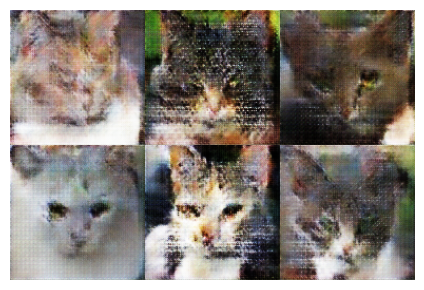

Epoch 40 | Discriminator loss: 0.32544921265602034 | Generator loss: 4.519998281823923


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 41 | Discriminator loss: 0.3228966902516387 | Generator loss: 4.323894148195012


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 42 | Discriminator loss: 0.3131522654094449 | Generator loss: 4.374307454557893


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 43 | Discriminator loss: 0.29230159668359135 | Generator loss: 4.512732742273289


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 44 | Discriminator loss: 0.285307487220572 | Generator loss: 4.644150210278375


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 45 | Discriminator loss: 0.2717727198648746 | Generator loss: 4.684116423685358


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 46 | Discriminator loss: 0.28324556803887185 | Generator loss: 4.841977246059394


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 47 | Discriminator loss: 0.2622589149568386 | Generator loss: 4.758498081694478


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 48 | Discriminator loss: 0.28987742836100533 | Generator loss: 4.679316822786509


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 49 | Discriminator loss: 0.27903616993113833 | Generator loss: 4.58603368097951


  0%|          | 0/645 [00:00<?, ?it/s]

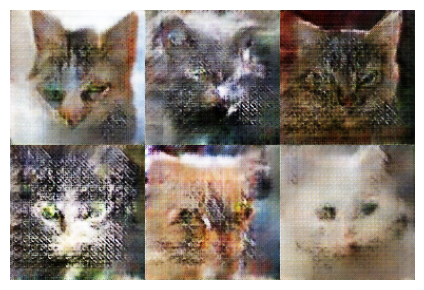

Epoch 50 | Discriminator loss: 0.28955759062482517 | Generator loss: 4.643534938370959


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 51 | Discriminator loss: 0.2661948000615246 | Generator loss: 4.633515941800538


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 52 | Discriminator loss: 0.27490838947734764 | Generator loss: 4.872336016308447


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 53 | Discriminator loss: 0.30785142414162514 | Generator loss: 4.487659129111663


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 54 | Discriminator loss: 0.283568818244162 | Generator loss: 4.620164991720863


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 55 | Discriminator loss: 0.26023241113129786 | Generator loss: 4.836908591645105


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 56 | Discriminator loss: 0.2644350529976606 | Generator loss: 4.78752880325969


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 57 | Discriminator loss: 0.2741928425442503 | Generator loss: 4.732144805400268


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 58 | Discriminator loss: 0.27035396976174897 | Generator loss: 4.833151985954794


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 59 | Discriminator loss: 0.24738695220473986 | Generator loss: 4.81070343603999


  0%|          | 0/645 [00:00<?, ?it/s]

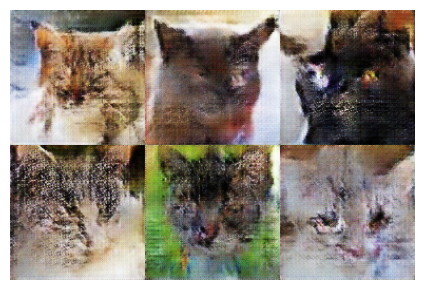

Epoch 60 | Discriminator loss: 0.24311042217525355 | Generator loss: 4.8829893279149665


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 61 | Discriminator loss: 0.2428520389356557 | Generator loss: 4.874964573553631


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 62 | Discriminator loss: 0.2573375532789971 | Generator loss: 4.89279199951554


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 63 | Discriminator loss: 0.221735248738951 | Generator loss: 5.085262833915142


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 64 | Discriminator loss: 0.2754940972999636 | Generator loss: 5.021159919337456


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 65 | Discriminator loss: 0.23019225941014562 | Generator loss: 4.9655923838756095


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 66 | Discriminator loss: 0.2282102157412376 | Generator loss: 5.101612480530828


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 67 | Discriminator loss: 0.22771102153565428 | Generator loss: 5.105112844372388


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 68 | Discriminator loss: 0.2320473969009929 | Generator loss: 5.096436089610461


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 69 | Discriminator loss: 0.2316650395069328 | Generator loss: 5.036202569926007


  0%|          | 0/645 [00:00<?, ?it/s]

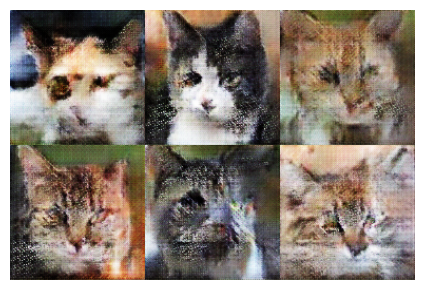

Epoch 70 | Discriminator loss: 0.22599538460076898 | Generator loss: 5.313804420717755


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 71 | Discriminator loss: 0.2167220764604083 | Generator loss: 5.226068216821422


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 72 | Discriminator loss: 0.2246588161841989 | Generator loss: 5.196317345019638


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 73 | Discriminator loss: 0.2142632253224487 | Generator loss: 5.328865965515931


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 74 | Discriminator loss: 0.22257020978708542 | Generator loss: 5.123015665489694


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 75 | Discriminator loss: 0.22440334277128313 | Generator loss: 5.176335536174893


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 76 | Discriminator loss: 0.2291936658769854 | Generator loss: 5.345397663042412


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 77 | Discriminator loss: 0.205874425920744 | Generator loss: 5.076331651914193


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 78 | Discriminator loss: 0.20691196918965782 | Generator loss: 5.356893149777229


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 79 | Discriminator loss: 0.2094680821014691 | Generator loss: 5.2329161877957935


  0%|          | 0/645 [00:00<?, ?it/s]

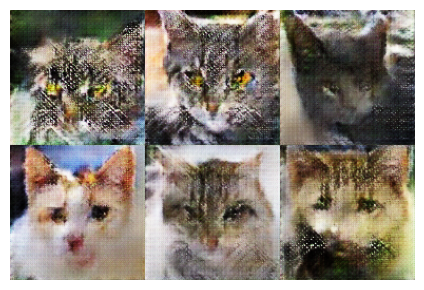

Epoch 80 | Discriminator loss: 0.21230702347982336 | Generator loss: 5.163408432225263


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 81 | Discriminator loss: 0.2003697952945786 | Generator loss: 5.518670692947341


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 82 | Discriminator loss: 0.2233545233310654 | Generator loss: 5.485775994310468


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 83 | Discriminator loss: 0.2213707206559611 | Generator loss: 5.171999080673508


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 84 | Discriminator loss: 0.20344099202519608 | Generator loss: 5.125887213101298


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 85 | Discriminator loss: 0.1822262811706748 | Generator loss: 5.366001587291682


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 86 | Discriminator loss: 0.18916862509067317 | Generator loss: 5.377663349698049


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 87 | Discriminator loss: 0.184050127814913 | Generator loss: 5.485520567768109


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 88 | Discriminator loss: 0.2276382645553797 | Generator loss: 5.603574020336874


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 89 | Discriminator loss: 0.21583124532409334 | Generator loss: 5.374439552704


  0%|          | 0/645 [00:00<?, ?it/s]

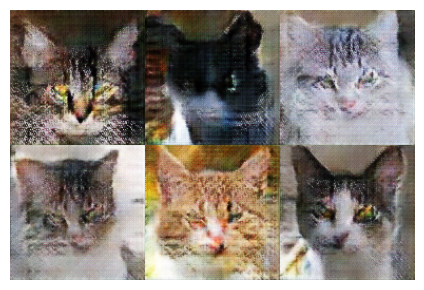

Epoch 90 | Discriminator loss: 0.19803870487520844 | Generator loss: 5.314173605501281


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 91 | Discriminator loss: 0.191054083246385 | Generator loss: 5.409644783283612


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 92 | Discriminator loss: 0.19050320232641613 | Generator loss: 5.596963626442489


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 93 | Discriminator loss: 0.17390232529463148 | Generator loss: 5.715676808024045


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 94 | Discriminator loss: 0.15578168353203023 | Generator loss: 5.574073719497052


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 95 | Discriminator loss: 0.1911003544639991 | Generator loss: 5.640099966840714


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 96 | Discriminator loss: 0.1705375396887635 | Generator loss: 5.661133902783719


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 97 | Discriminator loss: 0.19218502216057426 | Generator loss: 5.547188030359168


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 98 | Discriminator loss: 0.17839185520002698 | Generator loss: 5.613040479628936


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 99 | Discriminator loss: 0.1742997684871323 | Generator loss: 5.662024035957289


  0%|          | 0/645 [00:00<?, ?it/s]

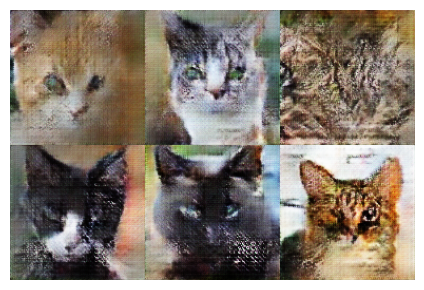

Epoch 100 | Discriminator loss: 0.1700656729868278 | Generator loss: 5.7208450034908624


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 101 | Discriminator loss: 0.1786050319963417 | Generator loss: 5.683513513262968


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 102 | Discriminator loss: 0.17470611469721203 | Generator loss: 5.581104881922651


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 103 | Discriminator loss: 0.18392073644362864 | Generator loss: 5.86644355203054


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 104 | Discriminator loss: 0.18231745735108987 | Generator loss: 5.4131322436451175


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 105 | Discriminator loss: 0.16331308846819761 | Generator loss: 5.669597589821549


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 106 | Discriminator loss: 0.19361045484697922 | Generator loss: 5.871333693310341


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 107 | Discriminator loss: 0.15295364398478214 | Generator loss: 5.646392937032332


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 108 | Discriminator loss: 0.16594240716926445 | Generator loss: 6.027619971992066


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 109 | Discriminator loss: 0.16796792658520207 | Generator loss: 5.960016997704595


  0%|          | 0/645 [00:00<?, ?it/s]

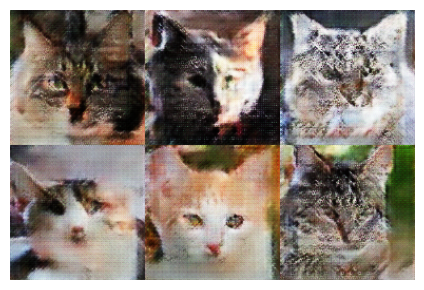

Epoch 110 | Discriminator loss: 0.17589852945908507 | Generator loss: 5.805340706052617


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 111 | Discriminator loss: 0.15001419996225399 | Generator loss: 5.853518854109397


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 112 | Discriminator loss: 0.16334191614056384 | Generator loss: 5.989725862045466


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 113 | Discriminator loss: 0.17277175749830342 | Generator loss: 5.835428017266789


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 114 | Discriminator loss: 0.1481386877915148 | Generator loss: 5.981043334749544


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 115 | Discriminator loss: 0.18537368841688617 | Generator loss: 5.87884769750678


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 116 | Discriminator loss: 0.15640982035385612 | Generator loss: 5.831017260040555


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 117 | Discriminator loss: 0.15048472662152243 | Generator loss: 6.065052380287869


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 118 | Discriminator loss: 0.1059938333091513 | Generator loss: 7.1379033367826334


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 119 | Discriminator loss: 0.024905486538630797 | Generator loss: 19.14938792938031


  0%|          | 0/645 [00:00<?, ?it/s]

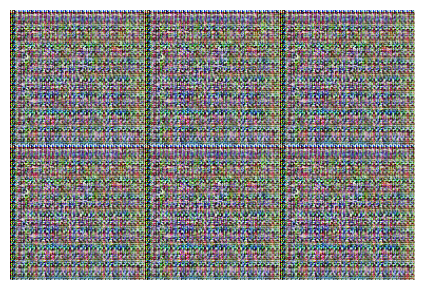

Epoch 120 | Discriminator loss: 2.6435329688911383e-06 | Generator loss: 52.13713626387697


In [ ]:
train_gan()